# Adult income

This notebook is focus on modeling using sklearn.

## 1. Data preparation

Algorithms for training need that the whole data is numeric, for that reason both categorical and target variables are going to be transformed into numeric values. In case of original numeric features the only transformation possible is scaling. However, that task was done during EDA process.

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
with open("configuration.json", "r") as f:
    data_configuration = json.load(f)

PATH_DATA = data_configuration["path_data"]

In [3]:
df_train = pd.read_csv(os.path.join(PATH_DATA, "adult_train_cleaned.csv"))
print("Shape:", df_train.shape)
df_train.head()

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,State-gov,0.044302,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.048238,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,0.138113,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,0.151068,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,0.221488,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba,<=50K


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  float64
 3   education       32561 non-null  object 
 4   education-num   32561 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      32561 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  float64
 11  capital-loss    32561 non-null  float64
 12  hours-per-week  32561 non-null  float64
 13  native-country  32561 non-null  object 
 14  income          32561 non-null  object 
dtypes: float64(6), object(9)
memory usage: 3.7+ MB


### 1.1. Categorical

The transformer selected is OneHotEncoder, because none of the variables had ordinal values. So, all classes have the same meaning with respect to weight or position.

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

In [7]:
# Get transformer instance 
# sparse_output = False to return the values as vectors
# drop = first to remove first class, because the rest of classes are enough explanatory and reduce training time 
onehot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# Training
encoded_features = onehot_encoder.fit_transform(df_train[categorical_features])

# Turn result into a dataframe
df_one_hot_encoder = pd.DataFrame(encoded_features, columns = onehot_encoder.get_feature_names_out())

### 1.2. Target variable

Turn text into a number with the values: 0 = <=50K and 1 = >50K.

In [8]:
target_variable = "income"
df_train[target_variable] = df_train[target_variable].map(lambda x: 0 if x == "<=50K" else 1)
df_train[target_variable].unique()

array([0, 1])

### 1.3. Get transformed dataset

In [9]:
numeric_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

df_train_encoded = pd.concat([df_train[numeric_features], df_one_hot_encoder, df_train[target_variable]], axis = 1)
print("Shape:", df_train_encoded.shape)
df_train_encoded.head()

Shape: (32561, 98)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.493151,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.150685,0.221488,0.800000,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## 2. Modeling

### 2.1. Split data into training and validation

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x = df_train_encoded.drop(target_variable, axis = 1).values
y = df_train_encoded[target_variable].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (26048, 97)
x_val shape: (6513, 97)
y_train shape: (26048,)
y_val shape: (6513,)


### 2.2. Training

For training models there are three main points:

* Test different machine learning algorithms for binary classification problem.
* Apply hyperparameter tuning using random search technique.
* Some hyperparameters like class_weight = balanced are set beforehand, because of class imbalance problem.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV

#### Logistic regression

In [13]:
lg = LogisticRegression(class_weight = "balanced")

param_grid = {
    # Regularization strength, smaller values specify stronger regularization
    "C": [0.01, 0.1, 1, 10, 100],

    # Optimizer algorithm
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],

    "penalty": ["l1", "l2", "elasticnet"]
}

clf = RandomizedSearchCV(lg, param_grid, random_state = 0, cv = 3, verbose = 2, n_jobs = -1)
random_search_lg = clf.fit(x_train, y_train)

print("\nBest hyperparameters:", random_search_lg.best_params_)
print("\nBest score: ", random_search_lg.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib


Best hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}

Best score:  0.8093136569148486


c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random forest

In [14]:
rfc = RandomForestClassifier()

param_grid = {
    # Number of trees to increase model complexity
    "n_estimators": [100, 200, 500],

    # Maximum depth of each tree
    "max_depth": [None, 10, 20, 30, 40, 50],

    # Minimum number of samples required to split an internal node, small number can lead to overfitting
    "min_samples_split": [2, 5, 10],

    # Minimum number of samples required to be at a leaf node, small number can lead to overfitting
    "min_samples_leaf": [1, 2, 4],

    # Number of features to consider when looking for the best split, small number reduce variance
    "max_features": ["auto", "sqrt", "log2"],

    # Add weights inversely proportional to each class based on its frequency
    "class_weight": ["balanced", "balanced_subsample"]
}

clf = RandomizedSearchCV(rfc, param_grid, random_state = 0, cv = 3, verbose = 2, n_jobs = -1)
random_search_rfc = clf.fit(x_train, y_train)

print("\nBest hyperparameters:", random_search_rfc.best_params_)
print("\nBest score: ", random_search_rfc.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    v


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'class_weight': 'balanced'}

Best score:  0.8511213017120668


#### Neural Networks

In [15]:
mlpc = MLPClassifier()

param_grid = {
    # Number of neurons in each hidden layer, more layers, more complex model
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50), (100, 100)],

    # Activation function for the hidden layers
    "activation": ["identity", "logistic", "tanh", "relu"],

    # Optimizer algorithm
    "solver": ["lbfgs", "sgd", "adam"],

    # L2 penalty strength
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],

    # How learning rate changes
    "learning_rate": ["constant", "invscaling", "adaptive"],

    # Initial learning rate used
    "learning_rate_init": [0.001, 0.01, 0.1],

    # Maximum number of iterations
    "max_iter": [200, 300, 500]
}

clf = RandomizedSearchCV(mlpc, param_grid, random_state = 0, cv = 3, verbose = 2, n_jobs = -1)
random_search_mlpc = clf.fit(x_train, y_train)

print("Best hyperparameters:", random_search_mlpc.best_params_)
print("Best score: ", random_search_mlpc.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'logistic'}
Best score:  0.8498925558126066


c:\ProgramData\anaconda3\envs\sklearn-env-1-5\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### 2.3. Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

#### Logistic regression

In [17]:
# Prediction
y_pred = random_search_lg.predict(x_val)

# Probabilities for ROC AUC
y_prob = random_search_lg.predict_proba(x_val)[:, 1]

# Classification Report
print("\nClassification Report:", classification_report(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:", confusion_matrix(y_val, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# Precision-Recall AUC Score
average_precision = average_precision_score(y_val, y_prob)
print("\nPrecision-Recall AUC Score:", average_precision)


Classification Report:               precision    recall  f1-score   support

           0       0.94      0.80      0.86      4942
           1       0.57      0.84      0.68      1571

    accuracy                           0.81      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513


Confusion Matrix: [[3932 1010]
 [ 244 1327]]

ROC AUC Score: 0.9070642753200009

Precision-Recall AUC Score: 0.7713603002026457


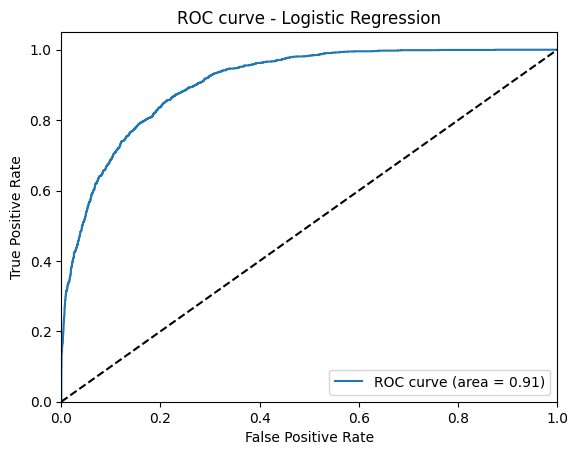

In [18]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Logistic Regression")
plt.legend(loc = "lower right")
plt.show()

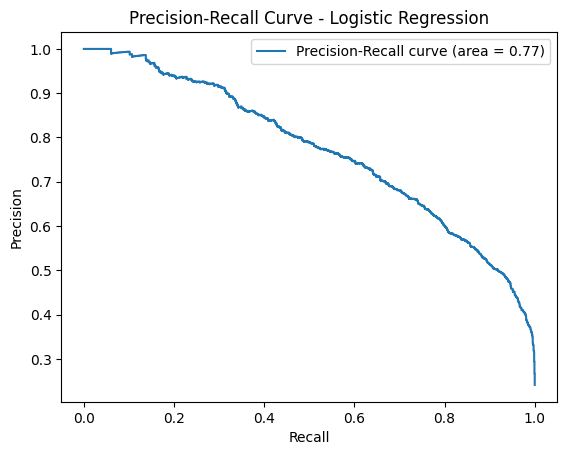

In [19]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure()
plt.step(recall, precision, where = "post", label = "Precision-Recall curve (area = %0.2f)" % average_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc = "best")
plt.show()

#### Random forest

In [20]:
y_pred = random_search_rfc.predict(x_val)
y_prob = random_search_rfc.predict_proba(x_val)[:, 1]

# Classification Report
print("\nClassification Report:", classification_report(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:", confusion_matrix(y_val, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# Precision-Recall AUC Score
average_precision = average_precision_score(y_val, y_prob)
print("\nPrecision-Recall AUC Score:", average_precision)


Classification Report:               precision    recall  f1-score   support

           0       0.90      0.92      0.91      4942
           1       0.72      0.67      0.69      1571

    accuracy                           0.86      6513
   macro avg       0.81      0.79      0.80      6513
weighted avg       0.86      0.86      0.86      6513


Confusion Matrix: [[4543  399]
 [ 522 1049]]

ROC AUC Score: 0.9066339493567779

Precision-Recall AUC Score: 0.7675470881800799


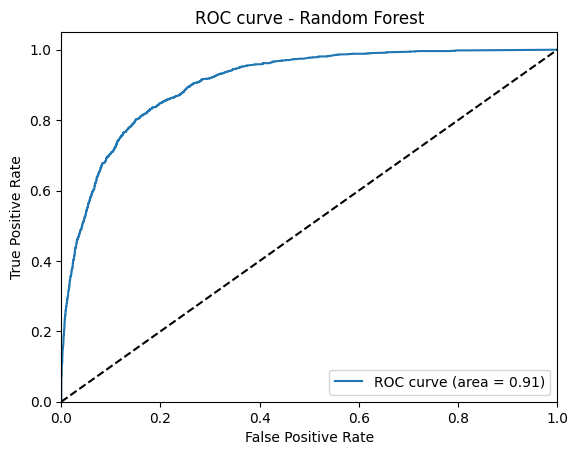

In [21]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Random Forest")
plt.legend(loc = "lower right")
plt.show()

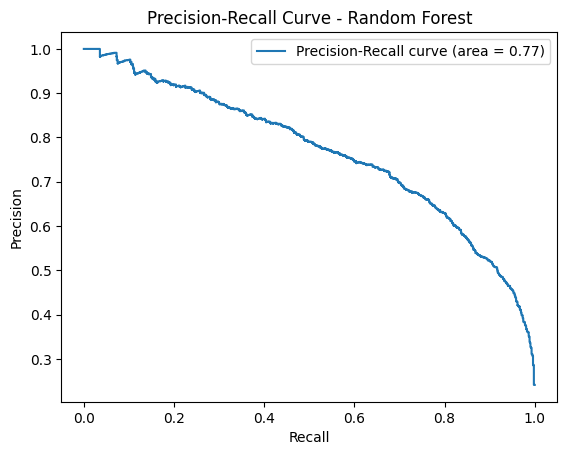

In [22]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure()
plt.step(recall, precision, where = "post", label = "Precision-Recall curve (area = %0.2f)" % average_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend(loc = "best")
plt.show()

#### Neural Networks

In [23]:
y_pred = random_search_mlpc.predict(x_val)
y_prob = random_search_mlpc.predict_proba(x_val)[:, 1]

# Classification Report
print("\nClassification Report:", classification_report(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:", confusion_matrix(y_val, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# Precision-Recall AUC Score
average_precision = average_precision_score(y_val, y_prob)
print("\nPrecision-Recall AUC Score:", average_precision)


Classification Report:               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4942
           1       0.73      0.62      0.67      1571

    accuracy                           0.85      6513
   macro avg       0.81      0.78      0.79      6513
weighted avg       0.85      0.85      0.85      6513


Confusion Matrix: [[4587  355]
 [ 592  979]]

ROC AUC Score: 0.9101346465595432

Precision-Recall AUC Score: 0.7821036804550894


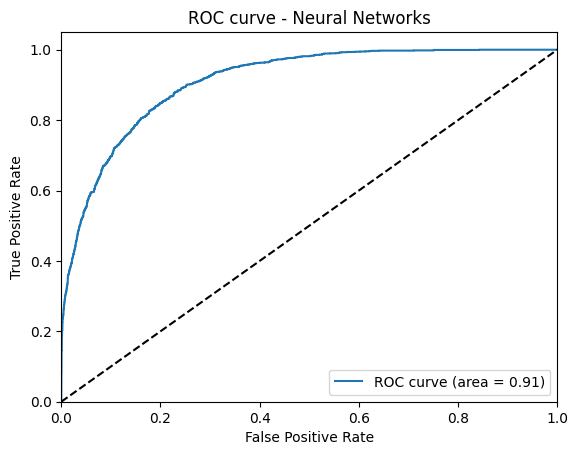

In [24]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Neural Networks")
plt.legend(loc = "lower right")
plt.show()

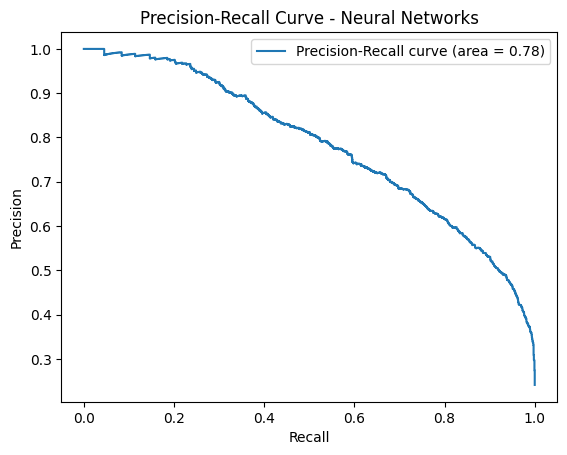

In [25]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure()
plt.step(recall, precision, where = "post", label = "Precision-Recall curve (area = %0.2f)" % average_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Neural Networks")
plt.legend(loc = "best")
plt.show()

### 2.4. Pipeline script

In [26]:
%%writefile src/adult_income_sklearn_script.py
import argparse
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type = str, help = "Data location")
args = parser.parse_args()
# Read data
print("\nReading data")
df_train = pd.read_csv(args.data_path)
print("\nData is done")

# Data for training and validation
print("\nStarting defining the data for training and validation")
target_variable = "income"
df_train = pd.read_csv(args.data_path)
x = df_train.drop(target_variable, axis = 1)
y = df_train[target_variable]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("\nData for training and testing are done")

# Data transformation
print("\nStarting applying target variable transformation")
y_train = y_train.map(lambda x: 0 if x == "<=50K" else 1)
y_val = y_val.map(lambda x: 0 if x == "<=50K" else 1)
print("\nTarget variable transformation is done")

print("\nStarting defining data transformation steps for categorical features")
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(sparse_output = False, drop = "first"), categorical_features)
    ])
print("\nData transformation for categorical features is done")

# Classifiers
print("\nStarting defining the classifiers")
logistic = LogisticRegression(class_weight = "balanced")
random_forest = RandomForestClassifier()
mlp = MLPClassifier()
print("\nClassifiers are done")

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", logistic)
])

# Hyperparameters per classifier
print("\nStarting defining the hyperparameters")
param_grid = [
    {
        "classifier": [logistic],

        # Regularization strength, smaller values specify stronger regularization
        "classifier__C": [0.01, 0.1, 1, 10, 100],

        # Optimizer algorithm
        "classifier__solver": ["liblinear", "sag", "saga"],

        "classifier__penalty": ["l2"]
    }
]
print("\nHyperparameters are done")

# Training
print("\nStarting training")
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter = 100, cv=3, verbose = 2, random_state = 42, n_jobs = -1)
random_search.fit(x_train, y_train)

print("Best hyperparameters:", random_search.best_params_)
print("Best score: ", random_search.best_score_)

print("\nTraining is done")

# Prediction
print("\nStarting evaluation")
y_pred = random_search.predict(x_val)

# Probabilities for ROC AUC
y_prob = random_search.predict_proba(x_val)[:, 1]

# Classification Report
print("\nClassification Report:", classification_report(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:", confusion_matrix(y_val, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# Precision-Recall AUC Score
average_precision = average_precision_score(y_val, y_prob)
print("\nPrecision-Recall AUC Score:", average_precision)

print("\Evaluation is done")

Overwriting src/adult_income_sklearn_script.py
